# DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [10]:
def actor_target(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor_target', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [11]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_target = actor_target(states=states, hidden_size=hidden_size, action_size=action_size)
    
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    
    return actions_target, loss

In [20]:
def model_opt(loss, learning_rate, gamma):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars_tgt = [var for var in t_vars if var.name.startswith('actor_target')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)
        
    opt_tgt = [g_vars_tgt[idx].assign((g_vars_tgt[idx]*gamma) + (g_vars[idx]*(1-gamma))) 
               for idx in range(len(g_vars_tgt))]
    
    return opt, opt_tgt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt, self.opt_tgt = model_opt(loss=self.loss, learning_rate=learning_rate, gamma=gamma)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [22]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [24]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [25]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
              gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
state = env.reset()
#for _ in range(batch_size):
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
                
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            
            sess.run(model.opt_tgt)
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:31.0000 R:31.0 loss:1.1589 exploreP:0.9969
Episode:1 meanR:25.5000 R:20.0 loss:1.0791 exploreP:0.9950
Episode:2 meanR:30.3333 R:40.0 loss:0.9900 exploreP:0.9910
Episode:3 meanR:28.0000 R:21.0 loss:0.8962 exploreP:0.9890
Episode:4 meanR:27.8000 R:27.0 loss:0.8189 exploreP:0.9863
Episode:5 meanR:26.0000 R:17.0 loss:0.7514 exploreP:0.9847
Episode:6 meanR:24.1429 R:13.0 loss:0.7178 exploreP:0.9834
Episode:7 meanR:23.1250 R:16.0 loss:0.7252 exploreP:0.9819
Episode:8 meanR:23.2222 R:24.0 loss:0.6851 exploreP:0.9795
Episode:9 meanR:23.6000 R:27.0 loss:0.6665 exploreP:0.9769
Episode:10 meanR:23.2727 R:20.0 loss:0.7023 exploreP:0.9750
Episode:11 meanR:22.0833 R:9.0 loss:0.7671 exploreP:0.9741
Episode:12 meanR:21.0769 R:9.0 loss:0.5496 exploreP:0.9732
Episode:13 meanR:22.2143 R:37.0 loss:0.6430 exploreP:0.9697
Episode:14 meanR:22.0000 R:19.0 loss:0.6926 exploreP:0.9679
Episode:15 meanR:21.7500 R:18.0 loss:0.5532 exploreP:0.9661
Episode:16 meanR:21.7059 R:21.0 loss:0.6288 exploreP

Episode:137 meanR:21.0800 R:21.0 loss:0.6039 exploreP:0.7512
Episode:138 meanR:20.9500 R:14.0 loss:0.6451 exploreP:0.7501
Episode:139 meanR:20.9300 R:12.0 loss:0.6414 exploreP:0.7492
Episode:140 meanR:20.9400 R:21.0 loss:0.6423 exploreP:0.7477
Episode:141 meanR:21.2400 R:42.0 loss:0.5902 exploreP:0.7446
Episode:142 meanR:21.2500 R:19.0 loss:0.6050 exploreP:0.7432
Episode:143 meanR:21.3200 R:26.0 loss:0.6347 exploreP:0.7413
Episode:144 meanR:21.2500 R:14.0 loss:0.6188 exploreP:0.7403
Episode:145 meanR:21.3200 R:19.0 loss:0.6341 exploreP:0.7389
Episode:146 meanR:21.0500 R:12.0 loss:0.5417 exploreP:0.7380
Episode:147 meanR:21.1900 R:26.0 loss:0.6244 exploreP:0.7361
Episode:148 meanR:21.2700 R:23.0 loss:0.5853 exploreP:0.7344
Episode:149 meanR:21.2800 R:11.0 loss:0.5889 exploreP:0.7336
Episode:150 meanR:21.1300 R:27.0 loss:0.6479 exploreP:0.7317
Episode:151 meanR:21.1400 R:17.0 loss:0.6730 exploreP:0.7305
Episode:152 meanR:21.0900 R:9.0 loss:0.6651 exploreP:0.7298
Episode:153 meanR:21.0800

Episode:275 meanR:20.6300 R:14.0 loss:0.6443 exploreP:0.5696
Episode:276 meanR:20.5300 R:10.0 loss:0.7709 exploreP:0.5691
Episode:277 meanR:20.4200 R:21.0 loss:0.6695 exploreP:0.5679
Episode:278 meanR:20.3500 R:10.0 loss:0.5866 exploreP:0.5674
Episode:279 meanR:20.3300 R:12.0 loss:0.6468 exploreP:0.5667
Episode:280 meanR:20.2600 R:16.0 loss:0.5665 exploreP:0.5658
Episode:281 meanR:20.2900 R:16.0 loss:0.5847 exploreP:0.5649
Episode:282 meanR:20.3300 R:23.0 loss:0.6344 exploreP:0.5636
Episode:283 meanR:20.3300 R:12.0 loss:0.5390 exploreP:0.5630
Episode:284 meanR:20.1200 R:13.0 loss:0.6504 exploreP:0.5623
Episode:285 meanR:20.0500 R:18.0 loss:0.6209 exploreP:0.5613
Episode:286 meanR:20.1300 R:27.0 loss:0.6787 exploreP:0.5598
Episode:287 meanR:20.2300 R:21.0 loss:0.7028 exploreP:0.5586
Episode:288 meanR:20.1400 R:14.0 loss:0.6536 exploreP:0.5579
Episode:289 meanR:20.0100 R:9.0 loss:0.5909 exploreP:0.5574
Episode:290 meanR:20.3000 R:44.0 loss:0.6468 exploreP:0.5550
Episode:291 meanR:20.2400

Episode:410 meanR:18.5900 R:17.0 loss:0.6933 exploreP:0.4494
Episode:411 meanR:18.5000 R:9.0 loss:0.7447 exploreP:0.4490
Episode:412 meanR:18.3700 R:12.0 loss:0.6554 exploreP:0.4485
Episode:413 meanR:18.5900 R:33.0 loss:0.6810 exploreP:0.4471
Episode:414 meanR:18.3900 R:8.0 loss:0.6717 exploreP:0.4467
Episode:415 meanR:18.5100 R:27.0 loss:0.6987 exploreP:0.4455
Episode:416 meanR:18.5000 R:10.0 loss:0.5983 exploreP:0.4451
Episode:417 meanR:18.3600 R:11.0 loss:0.6074 exploreP:0.4446
Episode:418 meanR:18.2200 R:16.0 loss:0.6549 exploreP:0.4439
Episode:419 meanR:18.2200 R:19.0 loss:0.6118 exploreP:0.4431
Episode:420 meanR:18.1500 R:12.0 loss:0.6655 exploreP:0.4426
Episode:421 meanR:17.9800 R:11.0 loss:0.6924 exploreP:0.4421
Episode:422 meanR:18.0800 R:18.0 loss:0.6854 exploreP:0.4413
Episode:423 meanR:17.9400 R:12.0 loss:0.6462 exploreP:0.4408
Episode:424 meanR:17.8700 R:9.0 loss:0.6775 exploreP:0.4404
Episode:425 meanR:17.8300 R:13.0 loss:0.6542 exploreP:0.4399
Episode:426 meanR:17.8000 R

Episode:549 meanR:17.6600 R:11.0 loss:0.7402 exploreP:0.3557
Episode:550 meanR:17.6900 R:17.0 loss:0.6466 exploreP:0.3552
Episode:551 meanR:17.7600 R:18.0 loss:0.7049 exploreP:0.3545
Episode:552 meanR:17.7400 R:11.0 loss:0.7210 exploreP:0.3542
Episode:553 meanR:17.7400 R:9.0 loss:0.7188 exploreP:0.3538
Episode:554 meanR:17.6800 R:9.0 loss:0.7157 exploreP:0.3535
Episode:555 meanR:17.9700 R:39.0 loss:0.7210 exploreP:0.3522
Episode:556 meanR:17.8100 R:14.0 loss:0.7504 exploreP:0.3517
Episode:557 meanR:17.7000 R:17.0 loss:0.6552 exploreP:0.3511
Episode:558 meanR:17.5900 R:11.0 loss:0.6544 exploreP:0.3508
Episode:559 meanR:17.6300 R:15.0 loss:0.7249 exploreP:0.3503
Episode:560 meanR:17.6200 R:10.0 loss:0.7633 exploreP:0.3499
Episode:561 meanR:17.7700 R:24.0 loss:0.7466 exploreP:0.3491
Episode:562 meanR:17.7500 R:10.0 loss:0.6989 exploreP:0.3488
Episode:563 meanR:17.5500 R:8.0 loss:0.6469 exploreP:0.3485
Episode:564 meanR:17.4900 R:15.0 loss:0.7334 exploreP:0.3480
Episode:565 meanR:17.7100 R

Episode:684 meanR:20.0000 R:30.0 loss:0.7404 exploreP:0.2781
Episode:685 meanR:19.8200 R:15.0 loss:0.7094 exploreP:0.2777
Episode:686 meanR:19.9500 R:26.0 loss:0.7380 exploreP:0.2770
Episode:687 meanR:20.1400 R:28.0 loss:0.7101 exploreP:0.2763
Episode:688 meanR:20.1800 R:33.0 loss:0.7004 exploreP:0.2754
Episode:689 meanR:20.0400 R:12.0 loss:0.7219 exploreP:0.2751
Episode:690 meanR:19.9700 R:16.0 loss:0.7537 exploreP:0.2747
Episode:691 meanR:19.8300 R:8.0 loss:0.7502 exploreP:0.2745
Episode:692 meanR:19.8900 R:26.0 loss:0.7195 exploreP:0.2738
Episode:693 meanR:19.6000 R:10.0 loss:0.6965 exploreP:0.2735
Episode:694 meanR:19.3000 R:25.0 loss:0.7438 exploreP:0.2729
Episode:695 meanR:19.2800 R:22.0 loss:0.7476 exploreP:0.2723
Episode:696 meanR:19.2800 R:10.0 loss:0.7747 exploreP:0.2720
Episode:697 meanR:19.2500 R:11.0 loss:0.6973 exploreP:0.2717
Episode:698 meanR:19.3000 R:33.0 loss:0.7432 exploreP:0.2709
Episode:699 meanR:19.3800 R:18.0 loss:0.7336 exploreP:0.2704
Episode:700 meanR:19.1300

Episode:820 meanR:17.5200 R:28.0 loss:0.7947 exploreP:0.2214
Episode:821 meanR:17.5500 R:23.0 loss:0.7444 exploreP:0.2209
Episode:822 meanR:17.6800 R:35.0 loss:0.7329 exploreP:0.2202
Episode:823 meanR:17.7100 R:15.0 loss:0.8094 exploreP:0.2199
Episode:824 meanR:17.5700 R:8.0 loss:0.7241 exploreP:0.2197
Episode:825 meanR:17.3900 R:20.0 loss:0.6909 exploreP:0.2193
Episode:826 meanR:17.5200 R:22.0 loss:0.7729 exploreP:0.2188
Episode:827 meanR:17.5200 R:32.0 loss:0.7448 exploreP:0.2182
Episode:828 meanR:17.3600 R:20.0 loss:0.6657 exploreP:0.2177
Episode:829 meanR:17.3700 R:9.0 loss:0.7599 exploreP:0.2176
Episode:830 meanR:17.3300 R:9.0 loss:0.7355 exploreP:0.2174
Episode:831 meanR:17.3000 R:22.0 loss:0.7089 exploreP:0.2169
Episode:832 meanR:17.4100 R:27.0 loss:0.6989 exploreP:0.2164
Episode:833 meanR:17.5900 R:26.0 loss:0.7581 exploreP:0.2158
Episode:834 meanR:17.4800 R:10.0 loss:0.7574 exploreP:0.2156
Episode:835 meanR:17.6400 R:25.0 loss:0.7702 exploreP:0.2151
Episode:836 meanR:17.7900 R

Episode:958 meanR:17.3700 R:35.0 loss:0.7251 exploreP:0.1752
Episode:959 meanR:17.3600 R:12.0 loss:0.6888 exploreP:0.1750
Episode:960 meanR:17.3600 R:10.0 loss:0.6856 exploreP:0.1749
Episode:961 meanR:17.3100 R:16.0 loss:0.7898 exploreP:0.1746
Episode:962 meanR:17.3300 R:11.0 loss:0.7104 exploreP:0.1744
Episode:963 meanR:17.4700 R:26.0 loss:0.7021 exploreP:0.1740
Episode:964 meanR:17.4600 R:10.0 loss:0.7511 exploreP:0.1738
Episode:965 meanR:17.4400 R:20.0 loss:0.8008 exploreP:0.1735
Episode:966 meanR:17.4700 R:29.0 loss:0.7615 exploreP:0.1730
Episode:967 meanR:17.3900 R:13.0 loss:0.7539 exploreP:0.1728
Episode:968 meanR:17.0000 R:9.0 loss:0.7708 exploreP:0.1727
Episode:969 meanR:16.9500 R:10.0 loss:0.7995 exploreP:0.1725
Episode:970 meanR:16.8500 R:8.0 loss:0.7927 exploreP:0.1724
Episode:971 meanR:16.8700 R:22.0 loss:0.7336 exploreP:0.1720
Episode:972 meanR:16.7500 R:12.0 loss:0.7409 exploreP:0.1718
Episode:973 meanR:16.8400 R:18.0 loss:0.7574 exploreP:0.1715
Episode:974 meanR:16.9000 

Episode:1096 meanR:17.6700 R:47.0 loss:0.7332 exploreP:0.1401
Episode:1097 meanR:17.5900 R:22.0 loss:0.7401 exploreP:0.1398
Episode:1098 meanR:17.7400 R:31.0 loss:0.7671 exploreP:0.1394
Episode:1099 meanR:17.6000 R:9.0 loss:0.7452 exploreP:0.1393
Episode:1100 meanR:17.5900 R:30.0 loss:0.7794 exploreP:0.1389
Episode:1101 meanR:17.5500 R:13.0 loss:0.7496 exploreP:0.1387
Episode:1102 meanR:17.5600 R:12.0 loss:0.7308 exploreP:0.1386
Episode:1103 meanR:17.7500 R:30.0 loss:0.7600 exploreP:0.1382
Episode:1104 meanR:17.5900 R:9.0 loss:0.7351 exploreP:0.1381
Episode:1105 meanR:17.4900 R:11.0 loss:0.7050 exploreP:0.1379
Episode:1106 meanR:17.4900 R:9.0 loss:0.7594 exploreP:0.1378
Episode:1107 meanR:17.5000 R:9.0 loss:0.7260 exploreP:0.1377
Episode:1108 meanR:17.5400 R:13.0 loss:0.7581 exploreP:0.1375
Episode:1109 meanR:17.7200 R:27.0 loss:0.7911 exploreP:0.1372
Episode:1110 meanR:17.8600 R:24.0 loss:0.7070 exploreP:0.1369
Episode:1111 meanR:17.9500 R:24.0 loss:0.7078 exploreP:0.1366
Episode:1112

Episode:1230 meanR:17.8900 R:11.0 loss:0.7275 exploreP:0.1125
Episode:1231 meanR:18.1400 R:34.0 loss:0.7353 exploreP:0.1121
Episode:1232 meanR:18.1300 R:8.0 loss:0.7446 exploreP:0.1121
Episode:1233 meanR:18.0600 R:17.0 loss:0.7331 exploreP:0.1119
Episode:1234 meanR:18.0600 R:9.0 loss:0.6840 exploreP:0.1118
Episode:1235 meanR:18.1000 R:25.0 loss:0.7014 exploreP:0.1115
Episode:1236 meanR:17.9300 R:9.0 loss:0.7081 exploreP:0.1114
Episode:1237 meanR:18.1200 R:30.0 loss:0.7686 exploreP:0.1111
Episode:1238 meanR:17.9300 R:11.0 loss:0.6723 exploreP:0.1110
Episode:1239 meanR:17.9100 R:8.0 loss:0.7513 exploreP:0.1109
Episode:1240 meanR:18.0600 R:24.0 loss:0.7582 exploreP:0.1107
Episode:1241 meanR:18.0700 R:9.0 loss:0.7548 exploreP:0.1106
Episode:1242 meanR:18.1700 R:21.0 loss:0.7563 exploreP:0.1104
Episode:1243 meanR:18.0200 R:9.0 loss:0.7906 exploreP:0.1103
Episode:1244 meanR:17.8700 R:9.0 loss:0.7282 exploreP:0.1102
Episode:1245 meanR:17.8700 R:9.0 loss:0.7337 exploreP:0.1101
Episode:1246 mea

Episode:1363 meanR:16.7900 R:26.0 loss:0.7515 exploreP:0.0922
Episode:1364 meanR:16.9200 R:22.0 loss:0.7987 exploreP:0.0920
Episode:1365 meanR:17.2800 R:46.0 loss:0.7524 exploreP:0.0916
Episode:1366 meanR:17.2800 R:9.0 loss:0.7788 exploreP:0.0915
Episode:1367 meanR:17.2600 R:9.0 loss:0.7265 exploreP:0.0915
Episode:1368 meanR:17.1400 R:9.0 loss:0.7759 exploreP:0.0914
Episode:1369 meanR:17.1800 R:14.0 loss:0.7658 exploreP:0.0913
Episode:1370 meanR:16.9100 R:8.0 loss:0.6550 exploreP:0.0912
Episode:1371 meanR:17.0400 R:31.0 loss:0.7628 exploreP:0.0910
Episode:1372 meanR:17.1800 R:23.0 loss:0.7663 exploreP:0.0908
Episode:1373 meanR:17.0900 R:24.0 loss:0.7486 exploreP:0.0906
Episode:1374 meanR:17.2800 R:27.0 loss:0.8053 exploreP:0.0904
Episode:1375 meanR:17.3100 R:22.0 loss:0.7579 exploreP:0.0902
Episode:1376 meanR:17.1700 R:9.0 loss:0.7434 exploreP:0.0901
Episode:1377 meanR:17.3800 R:30.0 loss:0.6849 exploreP:0.0899
Episode:1378 meanR:17.3500 R:23.0 loss:0.7209 exploreP:0.0897
Episode:1379 

Episode:1496 meanR:18.4400 R:27.0 loss:0.7510 exploreP:0.0743
Episode:1497 meanR:18.5600 R:20.0 loss:0.8064 exploreP:0.0741
Episode:1498 meanR:18.7400 R:33.0 loss:0.7471 exploreP:0.0739
Episode:1499 meanR:18.6100 R:8.0 loss:0.7616 exploreP:0.0739
Episode:1500 meanR:18.7600 R:23.0 loss:0.7915 exploreP:0.0737
Episode:1501 meanR:18.7800 R:22.0 loss:0.7654 exploreP:0.0736
Episode:1502 meanR:18.7100 R:9.0 loss:0.7025 exploreP:0.0735
Episode:1503 meanR:18.5500 R:8.0 loss:0.7634 exploreP:0.0735
Episode:1504 meanR:18.3000 R:9.0 loss:0.7852 exploreP:0.0734
Episode:1505 meanR:18.1300 R:9.0 loss:0.7112 exploreP:0.0734
Episode:1506 meanR:18.1300 R:10.0 loss:0.7053 exploreP:0.0733
Episode:1507 meanR:18.2100 R:22.0 loss:0.6941 exploreP:0.0732
Episode:1508 meanR:18.0500 R:12.0 loss:0.7198 exploreP:0.0731
Episode:1509 meanR:18.2500 R:30.0 loss:0.7693 exploreP:0.0729
Episode:1510 meanR:18.4800 R:42.0 loss:0.7490 exploreP:0.0726
Episode:1511 meanR:18.4900 R:12.0 loss:0.7356 exploreP:0.0726
Episode:1512 

Episode:1632 meanR:17.2100 R:22.0 loss:0.7685 exploreP:0.0610
Episode:1633 meanR:17.1200 R:13.0 loss:0.7992 exploreP:0.0609
Episode:1634 meanR:17.2600 R:22.0 loss:0.7970 exploreP:0.0608
Episode:1635 meanR:17.0900 R:10.0 loss:0.7701 exploreP:0.0607
Episode:1636 meanR:17.0500 R:22.0 loss:0.7356 exploreP:0.0606
Episode:1637 meanR:17.2100 R:24.0 loss:0.7832 exploreP:0.0605
Episode:1638 meanR:17.1500 R:9.0 loss:0.8323 exploreP:0.0605
Episode:1639 meanR:17.3200 R:26.0 loss:0.7585 exploreP:0.0603
Episode:1640 meanR:17.3900 R:25.0 loss:0.7352 exploreP:0.0602
Episode:1641 meanR:17.7100 R:40.0 loss:0.7853 exploreP:0.0600
Episode:1642 meanR:17.9200 R:30.0 loss:0.7714 exploreP:0.0599
Episode:1643 meanR:17.9300 R:9.0 loss:0.7366 exploreP:0.0598
Episode:1644 meanR:18.0800 R:26.0 loss:0.7457 exploreP:0.0597
Episode:1645 meanR:18.0800 R:9.0 loss:0.7403 exploreP:0.0596
Episode:1646 meanR:17.9300 R:9.0 loss:0.7418 exploreP:0.0596
Episode:1647 meanR:18.0700 R:25.0 loss:0.7508 exploreP:0.0595
Episode:1648

Episode:1768 meanR:17.3000 R:27.0 loss:0.7273 exploreP:0.0501
Episode:1769 meanR:17.5100 R:30.0 loss:0.7718 exploreP:0.0500
Episode:1770 meanR:17.2000 R:9.0 loss:0.7233 exploreP:0.0499
Episode:1771 meanR:17.2200 R:28.0 loss:0.7621 exploreP:0.0498
Episode:1772 meanR:17.0500 R:9.0 loss:0.7472 exploreP:0.0498
Episode:1773 meanR:17.2200 R:41.0 loss:0.7370 exploreP:0.0496
Episode:1774 meanR:17.3600 R:25.0 loss:0.7746 exploreP:0.0495
Episode:1775 meanR:17.3600 R:9.0 loss:0.7353 exploreP:0.0495
Episode:1776 meanR:17.5300 R:26.0 loss:0.7919 exploreP:0.0494
Episode:1777 meanR:17.6600 R:21.0 loss:0.7211 exploreP:0.0493
Episode:1778 meanR:17.7700 R:20.0 loss:0.7960 exploreP:0.0492
Episode:1779 meanR:17.9300 R:26.0 loss:0.7402 exploreP:0.0491
Episode:1780 meanR:17.9200 R:9.0 loss:0.7554 exploreP:0.0491
Episode:1781 meanR:17.9200 R:8.0 loss:0.7821 exploreP:0.0491
Episode:1782 meanR:18.1900 R:36.0 loss:0.7596 exploreP:0.0489
Episode:1783 meanR:18.3200 R:22.0 loss:0.7632 exploreP:0.0488
Episode:1784 

Episode:1902 meanR:19.1700 R:24.0 loss:0.7390 exploreP:0.0409
Episode:1903 meanR:19.2600 R:23.0 loss:0.7465 exploreP:0.0408
Episode:1904 meanR:19.2000 R:24.0 loss:0.7792 exploreP:0.0407
Episode:1905 meanR:19.2600 R:30.0 loss:0.7185 exploreP:0.0407
Episode:1906 meanR:19.2300 R:24.0 loss:0.7746 exploreP:0.0406
Episode:1907 meanR:19.2700 R:13.0 loss:0.7418 exploreP:0.0405
Episode:1908 meanR:19.0600 R:9.0 loss:0.7851 exploreP:0.0405
Episode:1909 meanR:19.0600 R:9.0 loss:0.7141 exploreP:0.0405
Episode:1910 meanR:19.0500 R:25.0 loss:0.7612 exploreP:0.0404
Episode:1911 meanR:18.9900 R:26.0 loss:0.7314 exploreP:0.0403
Episode:1912 meanR:18.7900 R:8.0 loss:0.6809 exploreP:0.0403
Episode:1913 meanR:18.7000 R:19.0 loss:0.7713 exploreP:0.0402
Episode:1914 meanR:18.9300 R:47.0 loss:0.7322 exploreP:0.0401
Episode:1915 meanR:19.0400 R:21.0 loss:0.6707 exploreP:0.0400
Episode:1916 meanR:19.1900 R:23.0 loss:0.7670 exploreP:0.0400
Episode:1917 meanR:19.4200 R:32.0 loss:0.7095 exploreP:0.0399
Episode:191

Episode:2037 meanR:19.7000 R:9.0 loss:0.7883 exploreP:0.0336
Episode:2038 meanR:19.5300 R:12.0 loss:0.6898 exploreP:0.0336
Episode:2039 meanR:19.5200 R:8.0 loss:0.7910 exploreP:0.0335
Episode:2040 meanR:19.6500 R:22.0 loss:0.7538 exploreP:0.0335
Episode:2041 meanR:19.7700 R:21.0 loss:0.7548 exploreP:0.0334
Episode:2042 meanR:19.5500 R:9.0 loss:0.7525 exploreP:0.0334
Episode:2043 meanR:19.7700 R:34.0 loss:0.7236 exploreP:0.0333
Episode:2044 meanR:19.9700 R:29.0 loss:0.7633 exploreP:0.0333
Episode:2045 meanR:20.1800 R:30.0 loss:0.7085 exploreP:0.0332
Episode:2046 meanR:20.2000 R:10.0 loss:0.7311 exploreP:0.0332
Episode:2047 meanR:19.9800 R:9.0 loss:0.6639 exploreP:0.0332
Episode:2048 meanR:20.2000 R:30.0 loss:0.7195 exploreP:0.0331
Episode:2049 meanR:20.0200 R:9.0 loss:0.6494 exploreP:0.0331
Episode:2050 meanR:19.7600 R:8.0 loss:0.7594 exploreP:0.0330
Episode:2051 meanR:19.6900 R:23.0 loss:0.7343 exploreP:0.0330
Episode:2052 meanR:19.7700 R:32.0 loss:0.7268 exploreP:0.0329
Episode:2053 m

Episode:2174 meanR:18.5900 R:40.0 loss:0.7402 exploreP:0.0284
Episode:2175 meanR:18.3500 R:8.0 loss:0.7753 exploreP:0.0284
Episode:2176 meanR:18.3700 R:24.0 loss:0.7763 exploreP:0.0284
Episode:2177 meanR:18.4600 R:19.0 loss:0.7107 exploreP:0.0283
Episode:2178 meanR:18.2900 R:9.0 loss:0.7230 exploreP:0.0283
Episode:2179 meanR:18.4000 R:21.0 loss:0.7583 exploreP:0.0283
Episode:2180 meanR:18.5400 R:29.0 loss:0.7254 exploreP:0.0282
Episode:2181 meanR:18.6900 R:24.0 loss:0.7065 exploreP:0.0282
Episode:2182 meanR:18.4600 R:9.0 loss:0.6817 exploreP:0.0282
Episode:2183 meanR:18.1500 R:9.0 loss:0.6553 exploreP:0.0282
Episode:2184 meanR:18.1000 R:8.0 loss:0.7375 exploreP:0.0281
Episode:2185 meanR:18.0900 R:8.0 loss:0.7240 exploreP:0.0281
Episode:2186 meanR:18.1600 R:15.0 loss:0.6546 exploreP:0.0281
Episode:2187 meanR:18.0200 R:9.0 loss:0.6737 exploreP:0.0281
Episode:2188 meanR:18.1000 R:33.0 loss:0.7372 exploreP:0.0280
Episode:2189 meanR:17.9600 R:8.0 loss:0.7740 exploreP:0.0280
Episode:2190 mea

Episode:2307 meanR:19.1900 R:10.0 loss:0.6591 exploreP:0.0244
Episode:2308 meanR:18.8900 R:8.0 loss:0.7815 exploreP:0.0244
Episode:2309 meanR:18.8900 R:26.0 loss:0.7654 exploreP:0.0244
Episode:2310 meanR:18.8800 R:8.0 loss:0.6843 exploreP:0.0244
Episode:2311 meanR:19.0800 R:28.0 loss:0.6931 exploreP:0.0243
Episode:2312 meanR:19.2300 R:24.0 loss:0.7106 exploreP:0.0243
Episode:2313 meanR:19.0900 R:9.0 loss:0.7677 exploreP:0.0243
Episode:2314 meanR:19.0600 R:22.0 loss:0.7066 exploreP:0.0243
Episode:2315 meanR:19.1800 R:21.0 loss:0.7175 exploreP:0.0242
Episode:2316 meanR:19.0600 R:10.0 loss:0.7161 exploreP:0.0242
Episode:2317 meanR:18.8900 R:8.0 loss:0.7292 exploreP:0.0242
Episode:2318 meanR:18.8700 R:13.0 loss:0.7172 exploreP:0.0242
Episode:2319 meanR:18.8700 R:9.0 loss:0.7344 exploreP:0.0242
Episode:2320 meanR:18.8500 R:8.0 loss:0.7231 exploreP:0.0242
Episode:2321 meanR:18.7300 R:24.0 loss:0.7552 exploreP:0.0241
Episode:2322 meanR:19.0000 R:36.0 loss:0.7004 exploreP:0.0241
Episode:2323 m

Episode:2441 meanR:18.6100 R:9.0 loss:0.7800 exploreP:0.0214
Episode:2442 meanR:18.8400 R:33.0 loss:0.7119 exploreP:0.0213
Episode:2443 meanR:18.9200 R:17.0 loss:0.7384 exploreP:0.0213
Episode:2444 meanR:19.0600 R:24.0 loss:0.7332 exploreP:0.0213
Episode:2445 meanR:18.8800 R:9.0 loss:0.6894 exploreP:0.0213
Episode:2446 meanR:19.0900 R:30.0 loss:0.7591 exploreP:0.0212
Episode:2447 meanR:18.9000 R:9.0 loss:0.7147 exploreP:0.0212
Episode:2448 meanR:18.7700 R:9.0 loss:0.7943 exploreP:0.0212
Episode:2449 meanR:18.6600 R:12.0 loss:0.7255 exploreP:0.0212
Episode:2450 meanR:18.7900 R:45.0 loss:0.7693 exploreP:0.0212
Episode:2451 meanR:18.7800 R:24.0 loss:0.7145 exploreP:0.0211
Episode:2452 meanR:18.8500 R:20.0 loss:0.7785 exploreP:0.0211
Episode:2453 meanR:18.8500 R:9.0 loss:0.7618 exploreP:0.0211
Episode:2454 meanR:18.9000 R:24.0 loss:0.7559 exploreP:0.0211
Episode:2455 meanR:18.9000 R:8.0 loss:0.7325 exploreP:0.0211
Episode:2456 meanR:18.7600 R:9.0 loss:0.7711 exploreP:0.0211
Episode:2457 me

Episode:2574 meanR:18.9000 R:26.0 loss:0.7462 exploreP:0.0188
Episode:2575 meanR:18.8600 R:24.0 loss:0.7074 exploreP:0.0188
Episode:2576 meanR:18.6800 R:8.0 loss:0.7327 exploreP:0.0188
Episode:2577 meanR:18.7000 R:28.0 loss:0.7402 exploreP:0.0188
Episode:2578 meanR:18.5200 R:8.0 loss:0.6479 exploreP:0.0187
Episode:2579 meanR:18.4600 R:22.0 loss:0.7317 exploreP:0.0187
Episode:2580 meanR:18.4600 R:9.0 loss:0.7764 exploreP:0.0187
Episode:2581 meanR:18.5900 R:22.0 loss:0.7333 exploreP:0.0187
Episode:2582 meanR:18.5900 R:9.0 loss:0.7532 exploreP:0.0187
Episode:2583 meanR:18.3800 R:9.0 loss:0.7554 exploreP:0.0187
Episode:2584 meanR:18.1100 R:9.0 loss:0.8105 exploreP:0.0187
Episode:2585 meanR:18.1200 R:9.0 loss:0.7555 exploreP:0.0187
Episode:2586 meanR:17.9700 R:10.0 loss:0.7365 exploreP:0.0187
Episode:2587 meanR:18.0700 R:19.0 loss:0.7655 exploreP:0.0186
Episode:2588 meanR:18.3700 R:39.0 loss:0.6981 exploreP:0.0186
Episode:2589 meanR:18.3700 R:9.0 loss:0.7266 exploreP:0.0186
Episode:2590 mea

Episode:2711 meanR:17.4400 R:28.0 loss:0.7176 exploreP:0.0170
Episode:2712 meanR:17.3900 R:10.0 loss:0.6558 exploreP:0.0170
Episode:2713 meanR:17.4000 R:9.0 loss:0.7963 exploreP:0.0170
Episode:2714 meanR:17.2600 R:12.0 loss:0.7182 exploreP:0.0170
Episode:2715 meanR:17.0800 R:8.0 loss:0.7041 exploreP:0.0170
Episode:2716 meanR:16.9800 R:10.0 loss:0.7437 exploreP:0.0170
Episode:2717 meanR:17.0000 R:11.0 loss:0.7209 exploreP:0.0169
Episode:2718 meanR:17.1700 R:26.0 loss:0.6953 exploreP:0.0169
Episode:2719 meanR:17.1700 R:9.0 loss:0.7018 exploreP:0.0169
Episode:2720 meanR:17.1700 R:9.0 loss:0.7064 exploreP:0.0169
Episode:2721 meanR:16.9200 R:9.0 loss:0.7471 exploreP:0.0169
Episode:2722 meanR:16.9200 R:9.0 loss:0.7499 exploreP:0.0169
Episode:2723 meanR:16.8000 R:9.0 loss:0.7491 exploreP:0.0169
Episode:2724 meanR:16.8600 R:15.0 loss:0.7230 exploreP:0.0169
Episode:2725 meanR:17.2600 R:48.0 loss:0.7402 exploreP:0.0169
Episode:2726 meanR:17.2700 R:10.0 loss:0.7715 exploreP:0.0168
Episode:2727 me

Episode:2846 meanR:18.8800 R:9.0 loss:0.7845 exploreP:0.0155
Episode:2847 meanR:19.1500 R:36.0 loss:0.7290 exploreP:0.0154
Episode:2848 meanR:19.1500 R:9.0 loss:0.7731 exploreP:0.0154
Episode:2849 meanR:19.1700 R:24.0 loss:0.7468 exploreP:0.0154
Episode:2850 meanR:19.0200 R:22.0 loss:0.7475 exploreP:0.0154
Episode:2851 meanR:19.0300 R:9.0 loss:0.7684 exploreP:0.0154
Episode:2852 meanR:19.2600 R:32.0 loss:0.7484 exploreP:0.0154
Episode:2853 meanR:19.5300 R:36.0 loss:0.7370 exploreP:0.0154
Episode:2854 meanR:19.5700 R:36.0 loss:0.7522 exploreP:0.0154
Episode:2855 meanR:19.7900 R:31.0 loss:0.7352 exploreP:0.0153
Episode:2856 meanR:19.9400 R:26.0 loss:0.7464 exploreP:0.0153
Episode:2857 meanR:19.7800 R:9.0 loss:0.7310 exploreP:0.0153
Episode:2858 meanR:19.7800 R:8.0 loss:0.6997 exploreP:0.0153
Episode:2859 meanR:19.5800 R:8.0 loss:0.7919 exploreP:0.0153
Episode:2860 meanR:19.7200 R:26.0 loss:0.7504 exploreP:0.0153
Episode:2861 meanR:19.9100 R:28.0 loss:0.7479 exploreP:0.0153
Episode:2862 m

Episode:2980 meanR:18.8200 R:27.0 loss:0.7014 exploreP:0.0142
Episode:2981 meanR:18.8300 R:22.0 loss:0.7161 exploreP:0.0142
Episode:2982 meanR:18.7800 R:21.0 loss:0.7500 exploreP:0.0142
Episode:2983 meanR:18.7700 R:8.0 loss:0.7357 exploreP:0.0142
Episode:2984 meanR:18.9100 R:22.0 loss:0.7490 exploreP:0.0142
Episode:2985 meanR:18.9100 R:9.0 loss:0.7350 exploreP:0.0142
Episode:2986 meanR:18.9000 R:8.0 loss:0.7702 exploreP:0.0142
Episode:2987 meanR:18.8400 R:22.0 loss:0.7341 exploreP:0.0142
Episode:2988 meanR:18.7100 R:22.0 loss:0.7586 exploreP:0.0142
Episode:2989 meanR:18.7200 R:9.0 loss:0.8020 exploreP:0.0142
Episode:2990 meanR:18.6200 R:24.0 loss:0.7113 exploreP:0.0142
Episode:2991 meanR:18.3500 R:9.0 loss:0.7246 exploreP:0.0142
Episode:2992 meanR:18.1400 R:8.0 loss:0.7967 exploreP:0.0142
Episode:2993 meanR:18.3000 R:24.0 loss:0.7511 exploreP:0.0141
Episode:2994 meanR:18.4400 R:23.0 loss:0.7016 exploreP:0.0141
Episode:2995 meanR:18.4600 R:10.0 loss:0.7423 exploreP:0.0141
Episode:2996 m

Episode:3115 meanR:18.2900 R:9.0 loss:0.7157 exploreP:0.0133
Episode:3116 meanR:18.1200 R:11.0 loss:0.7719 exploreP:0.0133
Episode:3117 meanR:18.0700 R:22.0 loss:0.7216 exploreP:0.0133
Episode:3118 meanR:18.0700 R:8.0 loss:0.7716 exploreP:0.0133
Episode:3119 meanR:18.1800 R:20.0 loss:0.7663 exploreP:0.0133
Episode:3120 meanR:18.2300 R:13.0 loss:0.7282 exploreP:0.0133
Episode:3121 meanR:18.2500 R:29.0 loss:0.7283 exploreP:0.0133
Episode:3122 meanR:18.2300 R:8.0 loss:0.7341 exploreP:0.0133
Episode:3123 meanR:18.1900 R:30.0 loss:0.7225 exploreP:0.0133
Episode:3124 meanR:18.1700 R:30.0 loss:0.7293 exploreP:0.0133
Episode:3125 meanR:18.3500 R:26.0 loss:0.7391 exploreP:0.0133
Episode:3126 meanR:18.5900 R:32.0 loss:0.7158 exploreP:0.0132
Episode:3127 meanR:18.7200 R:24.0 loss:0.7323 exploreP:0.0132
Episode:3128 meanR:18.7000 R:24.0 loss:0.7931 exploreP:0.0132
Episode:3129 meanR:18.7100 R:25.0 loss:0.7505 exploreP:0.0132
Episode:3130 meanR:18.5500 R:8.0 loss:0.6923 exploreP:0.0132
Episode:3131

Episode:3251 meanR:16.6900 R:9.0 loss:0.7404 exploreP:0.0126
Episode:3252 meanR:16.5600 R:24.0 loss:0.7165 exploreP:0.0126
Episode:3253 meanR:16.3700 R:9.0 loss:0.7497 exploreP:0.0126
Episode:3254 meanR:16.4600 R:18.0 loss:0.7724 exploreP:0.0126
Episode:3255 meanR:16.4800 R:11.0 loss:0.7994 exploreP:0.0126
Episode:3256 meanR:16.5900 R:20.0 loss:0.6767 exploreP:0.0126


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

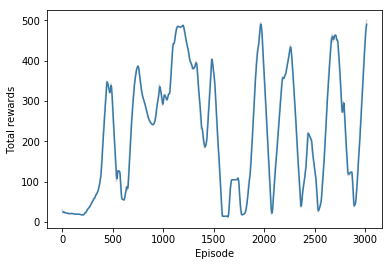

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

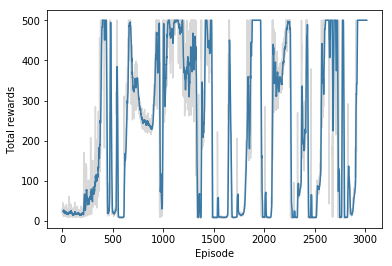

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

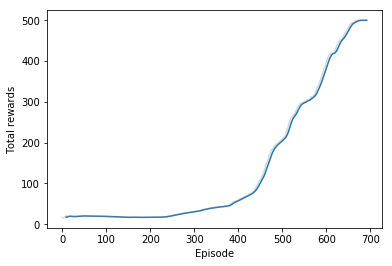

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

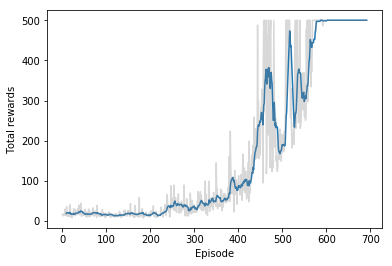

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

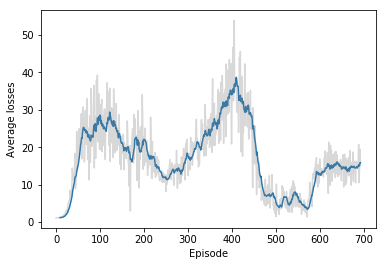

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Total rewards')

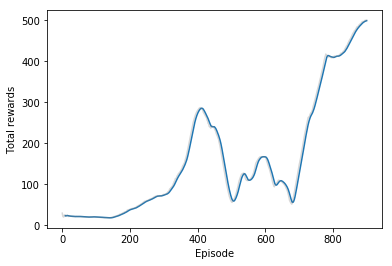

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

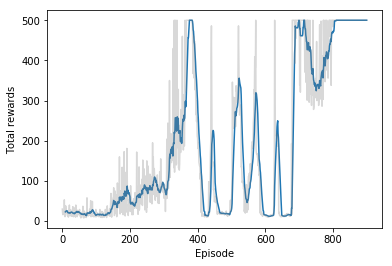

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

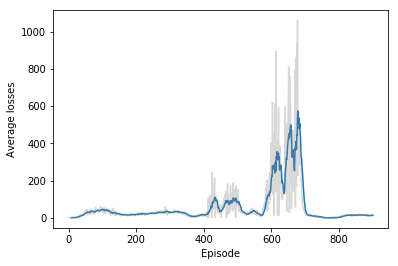

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.